# Building a Fraud Detection System

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mlp
%matplotlib inline

from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, precision_recall_curve, average_precision_score, roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import lightgbm as lgb

from numba import jit

/Users/diegomedina-bernal/miniconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [28]:
# Downloading data
!wget https://github.com/aapatel09/handson-unsupervised-learning/raw/master/datasets/credit_card_data/credit_card.csv 

--2019-05-10 01:14:33--  https://github.com/aapatel09/handson-unsupervised-learning/raw/master/datasets/credit_card_data/credit_card.csv
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/aapatel09/handson-unsupervised-learning/master/datasets/credit_card_data/credit_card.csv [following]
--2019-05-10 01:14:33--  https://media.githubusercontent.com/media/aapatel09/handson-unsupervised-learning/master/datasets/credit_card_data/credit_card.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 199.232.36.133
Connecting to media.githubusercontent.com (media.githubusercontent.com)|199.232.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150828752 (144M) [text/plain]
Saving to: ‘credit_card.csv.1’

credit_card.csv.1   100%[===================>] 143.84M  11.2MB/s    in 

In [32]:
# Let's move it to the appriopriate file
!mv credit_card.csv ./datasets/credit_card_data/credit_card_data.csv

# check the head
!head -n 3 ./datasets/credit_card_data/credit_card_data.csv

"Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","Class"
0,-1.3598071336738,-0.0727811733098497,2.53634673796914,1.37815522427443,-0.338320769942518,0.462387777762292,0.239598554061257,0.0986979012610507,0.363786969611213,0.0907941719789316,-0.551599533260813,-0.617800855762348,-0.991389847235408,-0.311169353699879,1.46817697209427,-0.470400525259478,0.207971241929242,0.0257905801985591,0.403992960255733,0.251412098239705,-0.018306777944153,0.277837575558899,-0.110473910188767,0.0669280749146731,0.128539358273528,-0.189114843888824,0.133558376740387,-0.0210530534538215,149.62,"0"
0,1.19185711131486,0.26615071205963,0.16648011335321,0.448154078460911,0.0600176492822243,-0.0823608088155687,-0.0788029833323113,0.0851016549148104,-0.255425128109186,-0.166974414004614,1.61272666105479,1.06523531137287,0.48909501589608,-0.143772296441519,0.635558093258208,0.4639170410

In [2]:
# Let's now load it into pandas
data = pd.read_csv('./datasets/credit_card_data/credit_card_data.csv')
data.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [34]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [35]:
columns = list(data.columns)

In [36]:
columns

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'Class']

In [40]:
# Let's look at the classifications
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

## Classes
As shown above, there are only two classes. ```0``` reppresents normal while ```1``` represents some fraud. 

### Standardization
We will then perform standardization which rescales the data to have a mean of zero and a standard deviation of one

*some machine learning solutions are very sensitive to the scale of the data, so having all the data on the same relative scale via standardization is a good machine learning practice.* 

*another common method to scale data is **normalization**, which rescales the data to a zero to one range. Unlike standarized data, all the normalized data is on a positive scale* 

In [41]:
# Checking for NaNs
data.isnull().any().sum()

0

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [50]:
%timeit data.nunique()

287 ms ± 8.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%timeit data.apply(lambda x: len(x.unique()))

283 ms ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
%%timeit

def uniquecount(el):
    return len(el.unique())

data.apply(uniquecount)

286 ms ± 4.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Generating Feature Matrix and Label Arrays
We will create and standardize the feature Matrix X and isolate the labels array y (1 = fraud, 0 = not fraud). 

In [3]:
data_X = data.copy().drop(['Class'], axis='columns')
data_y = data['Class'].copy()

In [4]:
data_X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [5]:
data_y.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

### Standarize the feature matrix X
We will now rescale the feature matrix so that each feature, except for time, has a mean of zero and a standard deviation of one

In [6]:
# Grabbing features we will scale
features_to_scale = data_X.drop(['Time'], axis='columns').columns

s_X  = pp.StandardScaler(copy=True)

# Standarizing
data_X.loc[:, features_to_scale] = s_X.fit_transform(data_X[features_to_scale])

In [7]:
data_X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,0.326118,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964
1,0.0,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,...,-0.089611,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475
2,1.0,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,...,0.680975,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686
3,1.0,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,...,-0.269855,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534
4,2.0,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,...,0.529939,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403


### Feature Engineering and Feature Selection
Feature Engineering involves creating new features, for example: calculating ratios or counts or sums from the original feature to help the machine learning algorithm extract a stronger signal from the dataset.

Feature selection involves selecting a subset of features for training, effectively removing some of the less relevant features from consideraton. This may help prevent the machine learning algorithm from overfitting to the noise in the dataset.

In our dataset, PCA has been performed on all features. 

# Model Prep
We need to split the data into a training and a test set, select a cost function, and prepare for k-fold cross-validation 

In [8]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.33, random_state=2018, stratify=data_y)

In [9]:
print(X_train.shape)
print(X_test.shape)

(190820, 30)
(93987, 30)


## Selecting Cost Function
Before we train on the training set, we need a cost function also referred to as the error rate or value function to pass into the machine learning algorithm. 

The machine learning algorithm will try to minimize this cost function by learning from training examples.

Given there are two classes and this is supervised learning, we will pick binary classification log loss. 

Which will calculate cross-entropy between the true labels and the model-based predictions. 

The closer the fraud probabilities are to the true labels, the lower the value of the log loss function. 

## Create k-Fold Cross-Validation State
We will further split the training data into both test and validation set to further evaluate and measure generalization better. 

In our case we are splitting our data into 5, therefor 1/5 will be validation while 4/5 will be training

In [10]:
# k = 5
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2018) 

### Model 1: Logistic Regression
We start with a basic classification algorithm. 

The stronger the regularization, the greater the penalty the machine learning algorithm applies to complexity. Therefor regularization nudges the machine learning algorithm to prefer simpler models to more complex ones.

Smaller value of ```C``` is stronger regularization. 

```class_weight='balanced'``` signals to the logistic regression algorithm that we have an imbalanced class problem (too few fraud examples), it will then weight the positive labels more heavily as it trains. 

The weights will be inversely proportional to the class fequencies; the algorithm will assign higher weights to the rare positive labels and lower weights to the more frequent negative labels. 

In [11]:
# Hyper parameters
penalty = 'l2'                # regularization
C = 1.0                       # regularization strength
class_weight = 'balanced'
random_state = 2018
solver = 'liblinear'
n_jobs = 1

log_regression = LogisticRegression(penalty=penalty, C=C, class_weight=class_weight, random_state=random_state, solver=solver, n_jobs=n_jobs)

In [16]:
training_score = []
cv_scores = []
predictions_based_on_k_folds = pd.DataFrame(data=[], index=y_train.index, columns=[0,1])

model = log_regression

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), y_train.ravel()):
    
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    # Fitting model
    model.fit(X_train_fold, y_train_fold)
    
    # Log loss
    log_loss_training = log_loss(y_train_fold, model.predict_proba(X_train_fold)[:, 1])
    
    training_score.append(log_loss_training)
    
    predictions_based_on_k_folds.loc[X_cv_fold.index, :] = model.predict_proba(X_cv_fold)
    
    log_loss_cv = log_loss(y_cv_fold, predictions_based_on_k_folds.loc[X_cv_fold.index, 1])
    
    cv_scores.append(log_loss_cv)
    
    print(f'Training log loss: {log_loss_training}')
    print(f'CV log loss: {log_loss_cv}')
    
log_loss_logistic_regression = log_loss(y_train, predictions_based_on_k_folds.loc[:,1])

print(f'Logistic Regression Log Loss: {log_loss_logistic_regression}')

Training log loss: 0.10312126363723864
CV log loss: 0.10891424425385518
Training log loss: 0.10808547228589843
CV log loss: 0.10349703681980418
Training log loss: 0.09345906662732105
CV log loss: 0.09507221692204695
Training log loss: 0.11765487752642477
CV log loss: 0.11832556578829838
Training log loss: 0.12369327017158406
CV log loss: 0.12197629101604389
Logistic Regression Log Loss: 0.10955707096000972


## Precision & Recall
Now we will further evaluate and inspect our first model with plotting our **precision recall curve**. This is to measure just how precise our model is at making predictions. Precision is the number of true positives over the number of total positive predictions: 

In our case, how many of the fraud transactions did our model catch? 

A high precision means that of all our positive predictions, many are true positives (having a low false positive rate). 

Recall is the number of true positives over the number of total actual positives in the dataset. In other words, how many of the fraud transactions does the model catch?

IF our solution has high precision but low recall, there would be a very small number of fraudulent transactions found but most would be truly fraudulent. 

IF our solution has low precision but high recall it would flag many of the transactions as fraudulent, thus catching a lot of fraud, but most of the flagged transactions would not be fraudulent.


We must find high precision and high recall. 

A graph of the trade-off between precision and recall is known as the precision-recall curve. 

The higher the average precision, the better the solution

## Receiver Operating Characteristic
Another good evaluation metric is the area under the receiver operating characteristic. The receiver operating characteristic curve plots the true positive rate on the Y axis and the false positive rate on the X axis.

The true positive rate can also be referred to as the sensitivity, and the false positive rate can also be referred to as the 1-specificity.

The closer the curve is to the top-left corner of the plot, the better the solution

Text(0.5, 1.0, 'Precision Recall Curve: Average Precision = 0.7200383065659999')

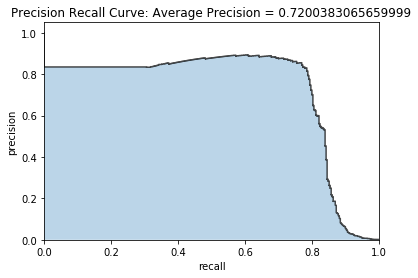

In [19]:
# Plotting the precision recall curve to understand how precise our model is 
preds = pd.concat([y_train, predictions_based_on_k_folds.loc[:,1]], axis=1)
preds.columns = ['true_label', 'prediction']

predictions_based_on_k_folds_logistic_regression = preds.copy()

precision, recall, thresholds = precision_recall_curve(preds['true_label'], preds['prediction'])

average_precision = average_precision_score(preds['true_label'], preds['prediction'])

# Plotting
plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3)

plt.xlabel('recall')
plt.ylabel('precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title(f'Precision Recall Curve: Average Precision = {average_precision}')

From this model, we have an average PRC, with an average precision of 72%. That is, at 80% recall, we have a 72% precision. 

This basically means, 72% were truly fraudulent (what the model flagged), while 28% were incorrectly flagged as fraudulent.

We will no go onto measure ROC

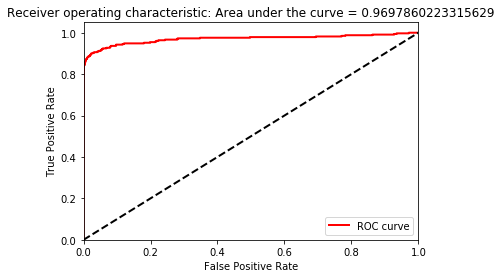

In [21]:
fpr, tpr, thresholds = roc_curve(preds['true_label'], preds['prediction'])

area_under_ROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0,1], [0,1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver operating characteristic: Area under the curve = {area_under_ROC}')
plt.legend(loc='lower right')
plt.show()

# Model 2: Random Forests
We will follow the same work-flow but now introduced another model: Random Forest.

In [22]:
# Setting hyperparameters
n_estimators = 10
max_features = 'auto'
max_depth = None
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0.0
max_leaf_nodes = None
bootstrap = True
oob_score = False
n_jobs = -1
random_state = 2018
class_weight = 'balanced'

RFC = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction_leaf, max_leaf_nodes=max_leaf_nodes, bootstrap=bootstrap, oob_score=oob_score, n_jobs=n_jobs, random_state=random_state, class_weight=class_weight)

In [24]:
# Training the model
training_scores = []
cv_scores = []
predictions_based_on_k_folds = pd.DataFrame(data=[], index=y_train.index, columns=[0,1])

model = RFC

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    model.fit(X_train_fold, y_train_fold)
    
    log_loss_training = log_loss(y_train_fold, model.predict_proba(X_train_fold))
    
    training_scores.append(log_loss_training)
    
    predictions_based_on_k_folds.loc[X_cv_fold.index,:] = model.predict_proba(X_cv_fold)
    
    log_loss_cv = log_loss(y_cv_fold, predictions_based_on_k_folds.loc[X_cv_fold.index,1])
    
    cv_scores.append(log_loss_cv)
    
    print(f'Training Log Loss: {log_loss_training}')
    print(f'CV Log Loss: {log_loss_cv}\n')
    
log_loss_random_forest_classifier = log_loss(y_train, predictions_based_on_k_folds.loc[:,1])

print(f'Random Forest Log Loss: {log_loss_random_forest_classifier}')

Training Log Loss: 0.00038666468324144877
CV Log Loss: 0.0153965105968685

Training Log Loss: 0.0004263217817373472
CV Log Loss: 0.010755953739346607

Training Log Loss: 0.0004088335711949752
CV Log Loss: 0.015386056391658222

Training Log Loss: 0.000430335389253032
CV Log Loss: 0.0047639585692903445

Training Log Loss: 0.00045596089565145143
CV Log Loss: 0.005619921221138471

Random Forest Log Loss: 0.010384480103660427


# Model 3: Gradient Boosting Machine (XGBoost)

In [25]:
# Setting hyperparameters
params_XGB = {
    'nthread':16,
    'learning rate':0.3,
    'gamma':0,
    'max_depth':6,
    'min_child_weight':1,
    'max_delta_step':0,
    'subsample':1.0,
    'colsample_bytree':1.0,
    'objective':'binary:logistic',
    'num_class':1,
    'eval_metric':'logloss',
    'seed':2018,
    'silent':1
}

# Training the model
training_scores = []
cv_scores = []
predictions_based_on_k_folds = pd.DataFrame(data=[], index=y_train.index, columns=[0,1])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    d_train = xgb.DMatrix(data=X_train_fold, label=y_train_fold)
    d_cv = xgb.DMatrix(data=X_cv_fold)
    
    bst = xgb.cv(params_XGB, d_train, num_boost_round=2000, nfold=5, early_stopping_rounds=200, verbose_eval=50)
    
    best_rounds = np.argmin(bst['test-logloss-mean'])
    bst = xgb.train(params_XGB, d_train, best_rounds)
    
    log_loss_training = log_loss(y_train_fold, bst.predict(d_train))
    training_scores.append(log_loss_training)
    
    predictions_based_on_k_folds.loc[X_cv_fold.index, 'prediction'] = bst.predict(d_cv)
    
    log_loss_cv = log_loss(y_cv_fold, predictions_based_on_k_folds.loc[X_cv_fold.index,'prediction'])
    
    cv_scores.append(log_loss_cv)
    
    print(f'Training Log Loss: {log_loss_training}')
    print(f'CV Log Loss: {log_loss_cv}\n')
    
log_loss_xgboost_gradient_boosting = log_loss(y_train, predictions_based_on_k_folds.loc[:,'prediction'])

print(f'XGBoost Gradient Boosting Log Loss: {log_loss_xgboost_gradient_boosting}')

# Model 4: Gradient Boosting Machine (LightGBM)

In [33]:
params_light_GB = {
    'task': 'train',
    'application': 'binary',
    'num_class': 1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq': 50,
    'is_training_metric': False,
    'max_depth': 4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0,
    'num_threads': 16
}

In [ ]:
# Training the model
training_scores = []
cv_scores = []
predictions_based_on_k_folds = pd.DataFrame(data=[], index=y_train.index, columns=['predictions'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, )